################################################

Owner: Arnab Das

Dataset: CIFAR10

##############################################

## Task 1: Experiments with Optimizers

In this task, you will investigate how different optimizers affect the training behavior.

Pick a architecture of your choice to train on Cifar10.
Train this architecture with different Optimizers and different hyperparameters.
Compare the training curves, e.g. regarding:

* steps until convergence
* training accuracy (or loss) when converged
* stability of training (fluctuation of the curve)

Now choose a different architecture and/or data set and repeat the experiments.
Are the results (qualitatively) still the same? If they are different, discuss potential reasons.

Bonus: Do not only compare visually, but use meaningful quantitative measures for comparison.

## Index

>* Necessary imports
>* Loading Cifar10 dataset and preprocessing
>* Sneak peek into the training images
>* The model
>* Training Experiment1: **LR variation for SGD** 
>* Training process plots
>* Training Experiment2: **Momentum variation for SGD**
>* Training process plots
>* Training Experiment3: **Batch size variation for SGD**
>* Training process plots
>* Training Experiment4: **LR variation for Adam**
>* Training process plots
>* Training Experiment5: **Batch size variation for SGD**
>* Training process plots
>* **Analysis** of above experiments & **SGD, Adam comparison**
>* Number of **epoch as hyper parameter** - Training Experiment6
>* Training process plot
>* **What's next?**: Performing same experiment with **another model and dataset**
>* Loading MNIST dataset and preporcessing
>* Sneak peek into the training images
>* Simple model creation
>* **Repeating same 5 experiments**  
>* **Comparing training process** for both **models**




In [ ]:
# Importing libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, Activation, Conv2DTranspose
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

#### Dataset and Preprocessing

##### loading Cifar 10 dataset and increasing the training data by repeating 2 times

In [ ]:
cifar10_dataset = keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10_dataset.load_data()
train_images=train_images.repeat(2,0)
train_labels=train_labels.repeat(2,0)

In [ ]:
# Printing the shape for trainining and testing dataset
print("Training images data shape is : {}".format(train_images.shape))
print("Training labels data shape is : {}".format(train_labels.shape))
print("Test images data shape is : {}".format(test_images.shape))
print("Test images data shape is : {}".format(test_labels.shape))

Training images data shape is : (100000, 32, 32, 3)
Training labels data shape is : (100000, 1)
Test images data shape is : (10000, 32, 32, 3)
Test images data shape is : (10000, 1)


##### Reshaping and normalizing training data set

In [ ]:
train_images = train_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255
test_images = test_images.reshape([-1, 32,32, 3]).astype(np.float32) / 255
train_labels = train_labels.astype(np.int32)
test_labels = test_labels.astype(np.int32)

In [ ]:
# Function to shuffle dataset
def shuffle_train_data(train_images, train_labels):
  permut = np.random.permutation(len(train_labels))
  x_shuf = train_images[permut]
  y_shuf = train_labels[permut]
  return x_shuf, y_shuf

In [ ]:
train_images, train_labels = shuffle_train_data(train_images, train_labels)

### Plotting the first 25 training image from the dataset. 

* This set is a collection of heterogeneous 10 classes. 
* The dataset contain RGB images and they are of share 32*32. Along with a depth of 3.
* Images belong to following classes --> "Airplane","Automobile","Bird","Cat","Deer","Dog","Frog","Horse","Ship","Truck"

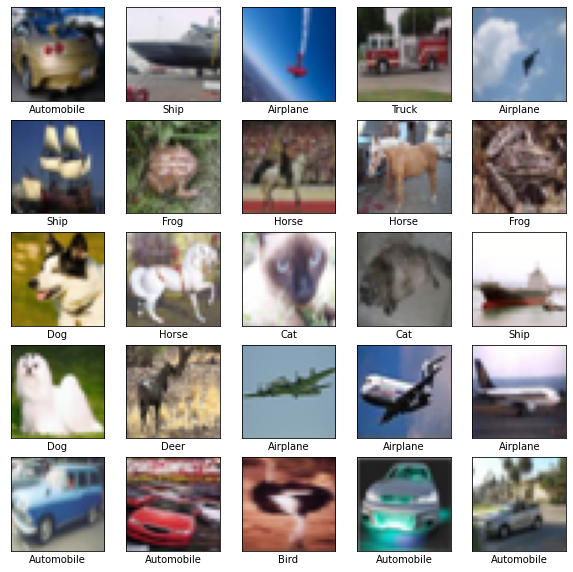

In [ ]:
classes = ["Airplane","Automobile","Bird","Cat","Deer","Dog","Frog","Horse","Ship","Truck"]
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(classes[int(train_labels[i])])
plt.show()

#### Building the first model for the task. This is relatively complex model, with BatchNormalization and Dropout to add regularization.

In [ ]:
# function to return the model
def createModel():
  return Sequential([
    Conv2D(32, 3, padding='same', input_shape = (32,32,3)),
    Activation('relu'),
    BatchNormalization(),
    Conv2D(64, 3, padding='same'),
    Activation('relu'),
    BatchNormalization(),
    Conv2D(64, 3),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
    Dropout(0.25),
    Conv2D(128, 5, padding='same'),
    Activation('relu'),
    BatchNormalization(),
    Conv2D(128, 5, padding = 'same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
    Dropout(0.25),
    Conv2D(256, 5, padding='same', name = 'conv_last'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
    Dropout(0.25),
    Conv2D(512, 2),
    Flatten(),
    Dense(256, activation = 'relu',kernel_regularizer=l2(0.01)),
    Dropout(0.25),
    Dense(512, activation = 'relu',kernel_regularizer=l2(0.01)),
    Dropout(0.25),
    Dense(1024, activation = 'relu',kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(10, activation = 'softmax')
    ])

### The Experiment:
> We will experiment with two optimizers, i.e. SGD and ADAM. For each of the type we will experiment with three hyper parameters, learning rate , monentum and batch size.

> And afterwards we will try to compare these by training curves of training accuracy, training loss, validation accuracy and validation loss.

>From that experiment we will choose the best performing configuration and will make it train longer with increased epoch to visualize how validation/test accuracy changes with increased training

#### Setting 1: Varying learning rate for SGD
* Optimizer : SGD
* Learning rate : [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
* Momentum : Default (Vanilla)
* Batchsize: 512
* epoch : 10

In [ ]:
sgd_LRVary_History = {}
sgd_LRVary_testResult = {}
for lRate in [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]:
  print("Traing for learning rate: ", lRate)
  mymodel = createModel()
  opt = tf.optimizers.SGD( learning_rate=lRate)
  mymodel.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])
  sgd_LRVary_History[lRate] = mymodel.fit(x=train_images, y=train_labels,batch_size=512, epochs=10, validation_split=0.2, verbose=0)
  print("Final training accuracy : {:.2f}".format(sgd_LRVary_History[lRate].history['accuracy'][-1]*100))
  print("Final validation accuracy : {:.2f}".format(sgd_LRVary_History[lRate].history['val_accuracy'][-1]*100))
  print("Final training loss : {:.2f}".format(sgd_LRVary_History[lRate].history['loss'][-1]))
  print("Final validation loss : {:.2f}".format(sgd_LRVary_History[lRate].history['val_loss'][-1]))
  test_loss, test_acc = mymodel.evaluate(test_images,  test_labels, verbose=2)
  print('Final test accuracy of this model : {:.2f}'.format(test_acc*100))
  sgd_LRVary_testResult[lRate] = (test_loss, test_acc)

Traing for learning rate:  0.001
Final training accuracy : 38.51
Final validation accuracy : 43.99
Final training loss : 15.64
Final validation loss : 15.42
313/313 - 1s - loss: 15.4356 - accuracy: 0.4252
Final test accuracy of this model : 42.52
Traing for learning rate:  0.005
Final training accuracy : 56.75
Final validation accuracy : 56.85
Final training loss : 12.17
Final validation loss : 11.98
313/313 - 1s - loss: 12.0129 - accuracy: 0.5490
Final test accuracy of this model : 54.90
Traing for learning rate:  0.01
Final training accuracy : 66.32
Final validation accuracy : 55.22
Final training loss : 9.10
Final validation loss : 9.22
313/313 - 1s - loss: 9.2642 - accuracy: 0.5408
Final test accuracy of this model : 54.08
Traing for learning rate:  0.02
Final training accuracy : 73.84
Final validation accuracy : 66.67
Final training loss : 5.24
Final validation loss : 5.13
313/313 - 1s - loss: 5.1949 - accuracy: 0.6451
Final test accuracy of this model : 64.51
Traing for learning 

###### Lets Visualize and different graphs for the settings 

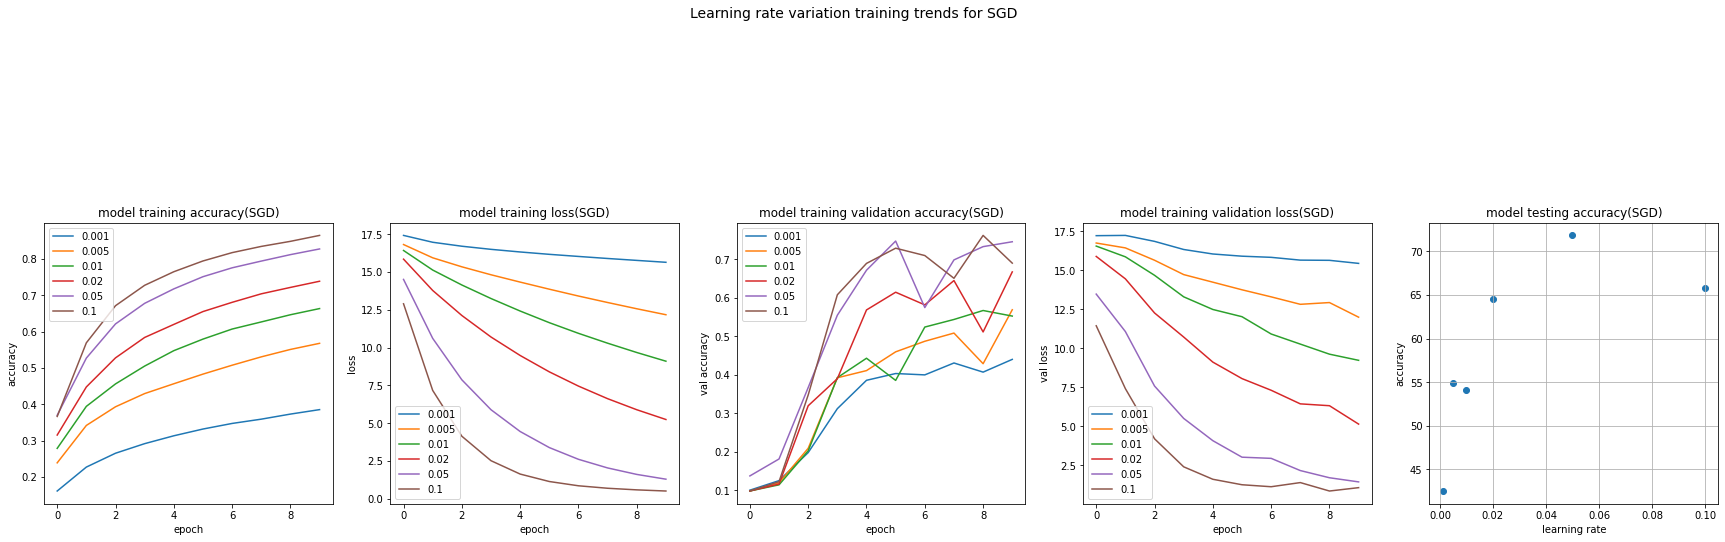

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.plot(sgd_LRVary_History[0.001].history['accuracy'])
plt.plot(sgd_LRVary_History[0.005].history['accuracy'])
plt.plot(sgd_LRVary_History[0.01].history['accuracy'])
plt.plot(sgd_LRVary_History[0.02].history['accuracy'])
plt.plot(sgd_LRVary_History[0.05].history['accuracy'])
plt.plot(sgd_LRVary_History[0.1].history['accuracy'])
plt.title('model training accuracy(SGD)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([0.001, 0.005, 0.01,0.02,0.05,0.1], loc='upper left')
plt.subplot(5,5,2)
plt.plot(sgd_LRVary_History[0.001].history['loss'])
plt.plot(sgd_LRVary_History[0.005].history['loss'])
plt.plot(sgd_LRVary_History[0.01].history['loss'])
plt.plot(sgd_LRVary_History[0.02].history['loss'])
plt.plot(sgd_LRVary_History[0.05].history['loss'])
plt.plot(sgd_LRVary_History[0.1].history['loss'])
plt.title('model training loss(SGD)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend([0.001, 0.005, 0.01,0.02,0.05,0.1], loc='lower left')
plt.subplot(5,5,3)
plt.plot(sgd_LRVary_History[0.001].history['val_accuracy'])
plt.plot(sgd_LRVary_History[0.005].history['val_accuracy'])
plt.plot(sgd_LRVary_History[0.01].history['val_accuracy'])
plt.plot(sgd_LRVary_History[0.02].history['val_accuracy'])
plt.plot(sgd_LRVary_History[0.05].history['val_accuracy'])
plt.plot(sgd_LRVary_History[0.1].history['val_accuracy'])
plt.title('model training validation accuracy(SGD)')
plt.ylabel('val accuracy')
plt.xlabel('epoch')
plt.legend([0.001, 0.005, 0.01,0.02,0.05,0.1], loc='upper left')
plt.subplot(5,5,4)
plt.plot(sgd_LRVary_History[0.001].history['val_loss'])
plt.plot(sgd_LRVary_History[0.005].history['val_loss'])
plt.plot(sgd_LRVary_History[0.01].history['val_loss'])
plt.plot(sgd_LRVary_History[0.02].history['val_loss'])
plt.plot(sgd_LRVary_History[0.05].history['val_loss'])
plt.plot(sgd_LRVary_History[0.1].history['val_loss'])
plt.title('model training validation loss(SGD)')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend([0.001, 0.005, 0.01,0.02,0.05,0.1], loc='lower left')
plt.suptitle("Learning rate variation training trends for SGD", fontsize=14)
plt.subplot(5,5,5)
plt.scatter([x for x in sgd_LRVary_testResult.keys()], [round(y*100,2) for x,y in sgd_LRVary_testResult.values()] )
plt.grid()
plt.title('model testing accuracy(SGD)')
plt.ylabel('accuracy')
plt.xlabel('learning rate')
plt.show()

#### Setting 2: Varying momentum for SGD
* Optimizer : SGD
* Learning rate : 0.05
* Momentum : [0,0.2,0.5,0.6,0.7,0.8]
* Batchsize: 512
* epoch : 10

In [ ]:
sgd_MmtVary_History = {}
sgd_MmtVary_testResult = {}
for mmt in [0,0.2,0.5,0.6,0.7,0.8]:
  print("##########################################")
  print("Traing for momentum: ", mmt)
  mymodel = createModel()
  opt = tf.optimizers.SGD( learning_rate=0.05, momentum=mmt)
  mymodel.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])
  sgd_MmtVary_History[mmt] = mymodel.fit(x=train_images, y=train_labels,batch_size=512, epochs=10, validation_split=0.2, verbose=0)
  print("Final training accuracy : {:.2f}".format(sgd_MmtVary_History[mmt].history['accuracy'][-1]*100))
  print("Final validation accuracy : {:.2f}".format(sgd_MmtVary_History[mmt].history['val_accuracy'][-1]*100))
  print("Final training loss : {:.2f}".format(sgd_MmtVary_History[mmt].history['loss'][-1]))
  print("Final validation loss : {:.2f}".format(sgd_MmtVary_History[mmt].history['val_loss'][-1]))
  test_loss, test_acc = mymodel.evaluate(test_images,  test_labels, verbose=2)
  print('Final test accuracy of this model : {:.2f}'.format(test_acc*100))
  sgd_MmtVary_testResult[mmt] = (test_loss, test_acc)

##########################################
Traing for momentum:  0
Final training accuracy : 82.33
Final validation accuracy : 68.73
Final training loss : 1.30
Final validation loss : 1.70
313/313 - 1s - loss: 1.8295 - accuracy: 0.6592
Final test accuracy of this model : 65.92
##########################################
Traing for momentum:  0.2
Final training accuracy : 84.32
Final validation accuracy : 75.93
Final training loss : 0.87
Final validation loss : 1.05
313/313 - 1s - loss: 1.1810 - accuracy: 0.7299
Final test accuracy of this model : 72.99
##########################################
Traing for momentum:  0.5
Final training accuracy : 86.89
Final validation accuracy : 83.71
Final training loss : 0.50
Final validation loss : 0.57
313/313 - 1s - loss: 0.7323 - accuracy: 0.7930
Final test accuracy of this model : 79.30
##########################################
Traing for momentum:  0.6
Final training accuracy : 88.13
Final validation accuracy : 82.98
Final training loss : 0.44


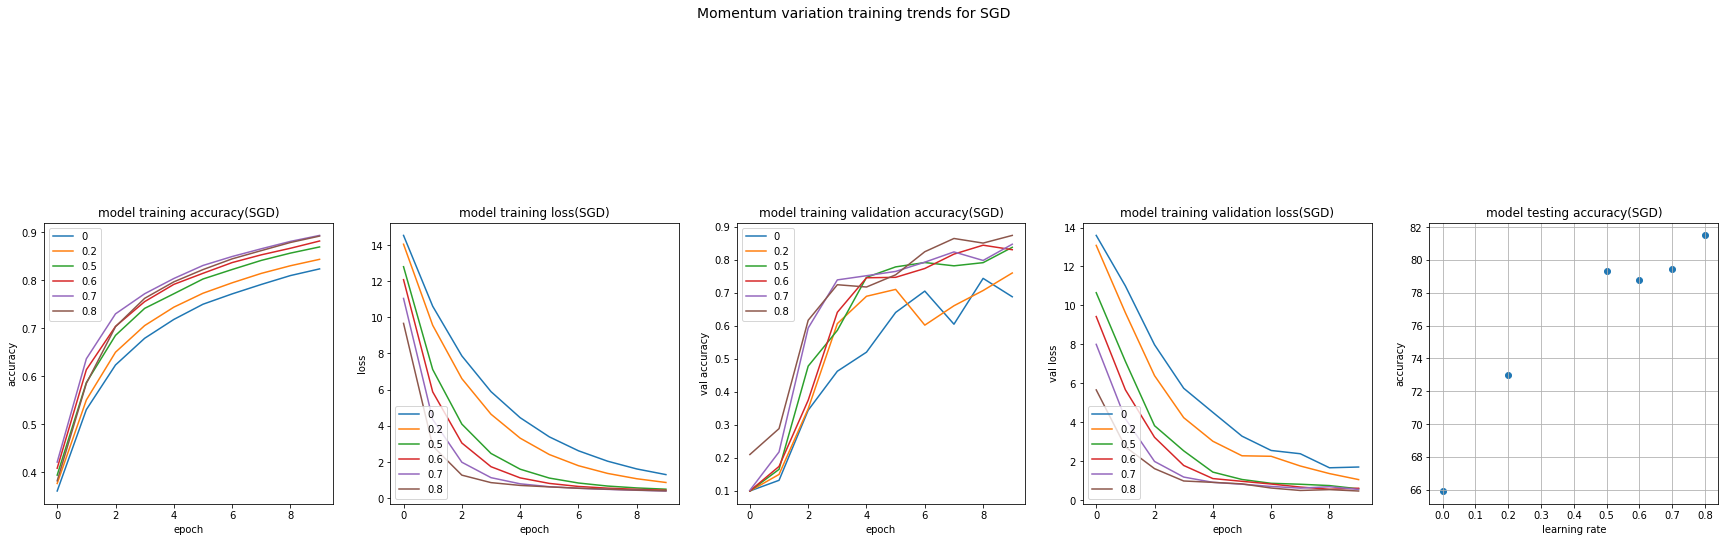

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.plot(sgd_MmtVary_History[0].history['accuracy'])
plt.plot(sgd_MmtVary_History[0.2].history['accuracy'])
plt.plot(sgd_MmtVary_History[0.5].history['accuracy'])
plt.plot(sgd_MmtVary_History[0.6].history['accuracy'])
plt.plot(sgd_MmtVary_History[0.7].history['accuracy'])
plt.plot(sgd_MmtVary_History[0.8].history['accuracy'])
plt.title('model training accuracy(SGD)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([0,0.2,0.5,0.6,0.7,0.8], loc='upper left')
plt.subplot(5,5,2)
plt.plot(sgd_MmtVary_History[0].history['loss'])
plt.plot(sgd_MmtVary_History[0.2].history['loss'])
plt.plot(sgd_MmtVary_History[0.5].history['loss'])
plt.plot(sgd_MmtVary_History[0.6].history['loss'])
plt.plot(sgd_MmtVary_History[0.7].history['loss'])
plt.plot(sgd_MmtVary_History[0.8].history['loss'])
plt.title('model training loss(SGD)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend([0,0.2,0.5,0.6,0.7,0.8], loc='lower left')
plt.subplot(5,5,3)
plt.plot(sgd_MmtVary_History[0].history['val_accuracy'])
plt.plot(sgd_MmtVary_History[0.2].history['val_accuracy'])
plt.plot(sgd_MmtVary_History[0.5].history['val_accuracy'])
plt.plot(sgd_MmtVary_History[0.6].history['val_accuracy'])
plt.plot(sgd_MmtVary_History[0.7].history['val_accuracy'])
plt.plot(sgd_MmtVary_History[0.8].history['val_accuracy'])
plt.title('model training validation accuracy(SGD)')
plt.ylabel('val accuracy')
plt.xlabel('epoch')
plt.legend([0,0.2,0.5,0.6,0.7,0.8], loc='upper left')
plt.subplot(5,5,4)
plt.plot(sgd_MmtVary_History[0].history['val_loss'])
plt.plot(sgd_MmtVary_History[0.2].history['val_loss'])
plt.plot(sgd_MmtVary_History[0.5].history['val_loss'])
plt.plot(sgd_MmtVary_History[0.6].history['val_loss'])
plt.plot(sgd_MmtVary_History[0.7].history['val_loss'])
plt.plot(sgd_MmtVary_History[0.8].history['val_loss'])
plt.title('model training validation loss(SGD)')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend([0,0.2,0.5,0.6,0.7,0.8], loc='lower left')
plt.suptitle("Momentum variation training trends for SGD", fontsize=14)
plt.subplot(5,5,5)
plt.scatter([x for x in sgd_MmtVary_testResult.keys()], [round(y*100,2) for x,y in sgd_MmtVary_testResult.values()] )
plt.grid()
plt.title('model testing accuracy(SGD)')
plt.ylabel('accuracy')
plt.xlabel('learning rate')
plt.show()

#### Setting 3: Varying batch size for SGD
* Optimizer : SGD
* Learning rate : 0.05
* Momentum : 0.8
* Batchsize: [128, 512, 2056, 4112] 
* epoch : 5

In [ ]:
losses = []
accuracy = []
class My_Callback(keras.callbacks.Callback):
    def on_batch_end(self, batch, logs={}):
        losses.append(logs.get('loss'))
        accuracy.append(logs.get('accuracy'))
        return

In [ ]:
sgd_BatchVary_History = {}
sgd_BatchVary_testResult = {}
sgd_BatchVary_step_loss = {}
sgd_BatchVary_step_acc= {}
for batch in [128, 512, 2056, 4112]:
  losses = []
  accuracy = []
  print("##########################################")
  print("Training for batch size: ", batch)
  mymodel = createModel()
  opt = tf.optimizers.SGD( learning_rate=0.05, momentum=0.8)
  mymodel.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])
  sgd_BatchVary_History[batch] = mymodel.fit(x=train_images, y=train_labels,batch_size=batch, epochs=5, validation_split=0.2, verbose=0, callbacks=[My_Callback()])
  print("Final training accuracy : {:.2f}".format(sgd_BatchVary_History[batch].history['accuracy'][-1]*100))
  print("Final validation accuracy : {:.2f}".format(sgd_BatchVary_History[batch].history['val_accuracy'][-1]*100))
  print("Final training loss : {:.2f}".format(sgd_BatchVary_History[batch].history['loss'][-1]))
  print("Final validation loss : {:.2f}".format(sgd_BatchVary_History[batch].history['val_loss'][-1]))
  test_loss, test_acc = mymodel.evaluate(test_images,  test_labels, verbose=2)
  print('Final test accuracy of this model : {:.2f}'.format(test_acc*100))
  sgd_BatchVary_testResult[batch] = (test_loss, test_acc)
  sgd_BatchVary_step_loss[batch] = losses
  sgd_BatchVary_step_acc[batch] = accuracy

##########################################
Training for batch size:  128
Final training accuracy : 73.62
Final validation accuracy : 76.65
Final training loss : 0.90
Final validation loss : 0.82
313/313 - 1s - loss: 0.8973 - accuracy: 0.7365
Final test accuracy of this model : 73.65
##########################################
Training for batch size:  512
Final training accuracy : 79.70
Final validation accuracy : 76.31
Final training loss : 0.70
Final validation loss : 0.78
313/313 - 1s - loss: 0.8646 - accuracy: 0.7366
Final test accuracy of this model : 73.66
##########################################
Training for batch size:  2056
Final training accuracy : 66.65
Final validation accuracy : 13.82
Final training loss : 3.59
Final validation loss : 4.60
313/313 - 1s - loss: 4.5942 - accuracy: 0.1338
Final test accuracy of this model : 13.38
##########################################
Training for batch size:  4112
Final training accuracy : 62.83
Final validation accuracy : 10.05
Final t

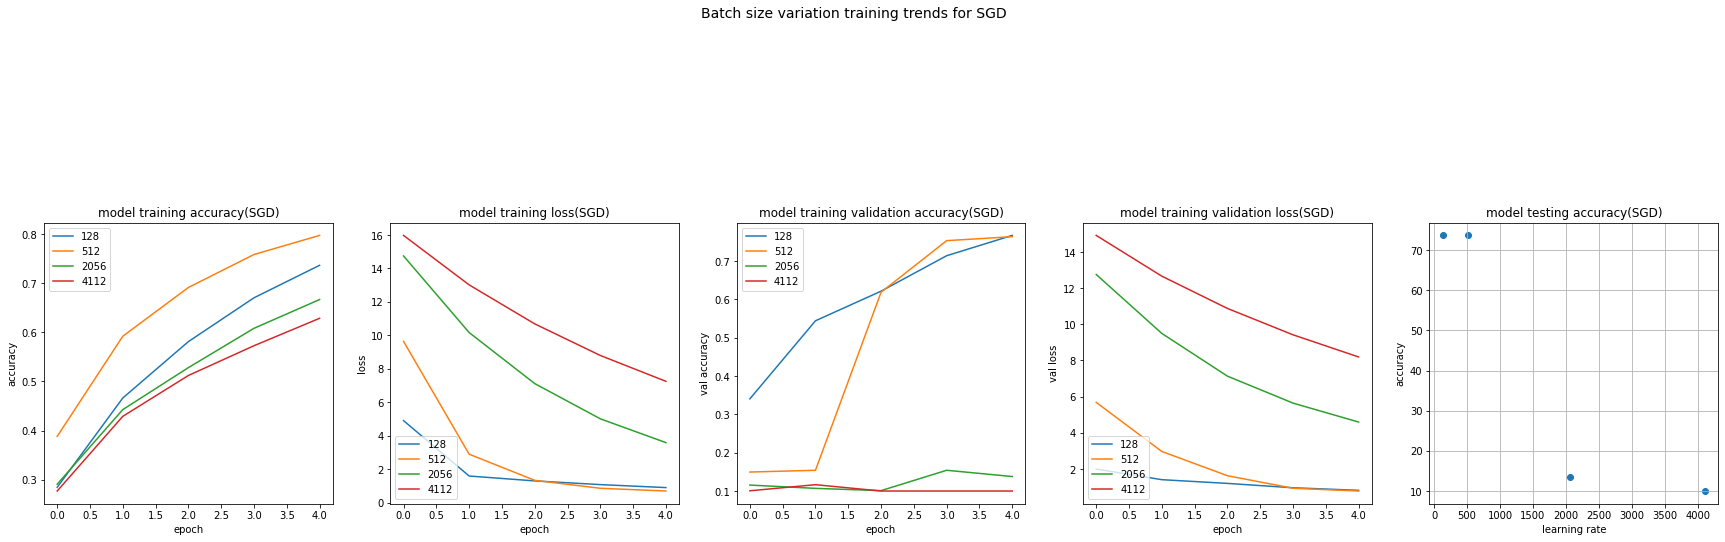

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.plot(sgd_BatchVary_History[128].history['accuracy'])
plt.plot(sgd_BatchVary_History[512].history['accuracy'])
plt.plot(sgd_BatchVary_History[2056].history['accuracy'])
plt.plot(sgd_BatchVary_History[4112].history['accuracy'])
plt.title('model training accuracy(SGD)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([128, 512, 2056, 4112], loc='upper left')
plt.subplot(5,5,2)
plt.plot(sgd_BatchVary_History[128].history['loss'])
plt.plot(sgd_BatchVary_History[512].history['loss'])
plt.plot(sgd_BatchVary_History[2056].history['loss'])
plt.plot(sgd_BatchVary_History[4112].history['loss'])
plt.title('model training loss(SGD)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend([128, 512, 2056, 4112], loc='lower left')
plt.subplot(5,5,3)
plt.plot(sgd_BatchVary_History[128].history['val_accuracy'])
plt.plot(sgd_BatchVary_History[512].history['val_accuracy'])
plt.plot(sgd_BatchVary_History[2056].history['val_accuracy'])
plt.plot(sgd_BatchVary_History[4112].history['val_accuracy'])
plt.title('model training validation accuracy(SGD)')
plt.ylabel('val accuracy')
plt.xlabel('epoch')
plt.legend([128, 512, 2056, 4112], loc='upper left')
plt.subplot(5,5,4)
plt.plot(sgd_BatchVary_History[128].history['val_loss'])
plt.plot(sgd_BatchVary_History[512].history['val_loss'])
plt.plot(sgd_BatchVary_History[2056].history['val_loss'])
plt.plot(sgd_BatchVary_History[4112].history['val_loss'])
plt.title('model training validation loss(SGD)')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend([128, 512, 2056, 4112], loc='lower left')
plt.suptitle("Batch size variation training trends for SGD", fontsize=14)
plt.subplot(5,5,5)
plt.scatter([x for x in sgd_BatchVary_testResult.keys()], [round(y*100,2) for x,y in sgd_BatchVary_testResult.values()] )
plt.grid()
plt.title('model testing accuracy(SGD)')
plt.ylabel('accuracy')
plt.xlabel('learning rate')
plt.show()

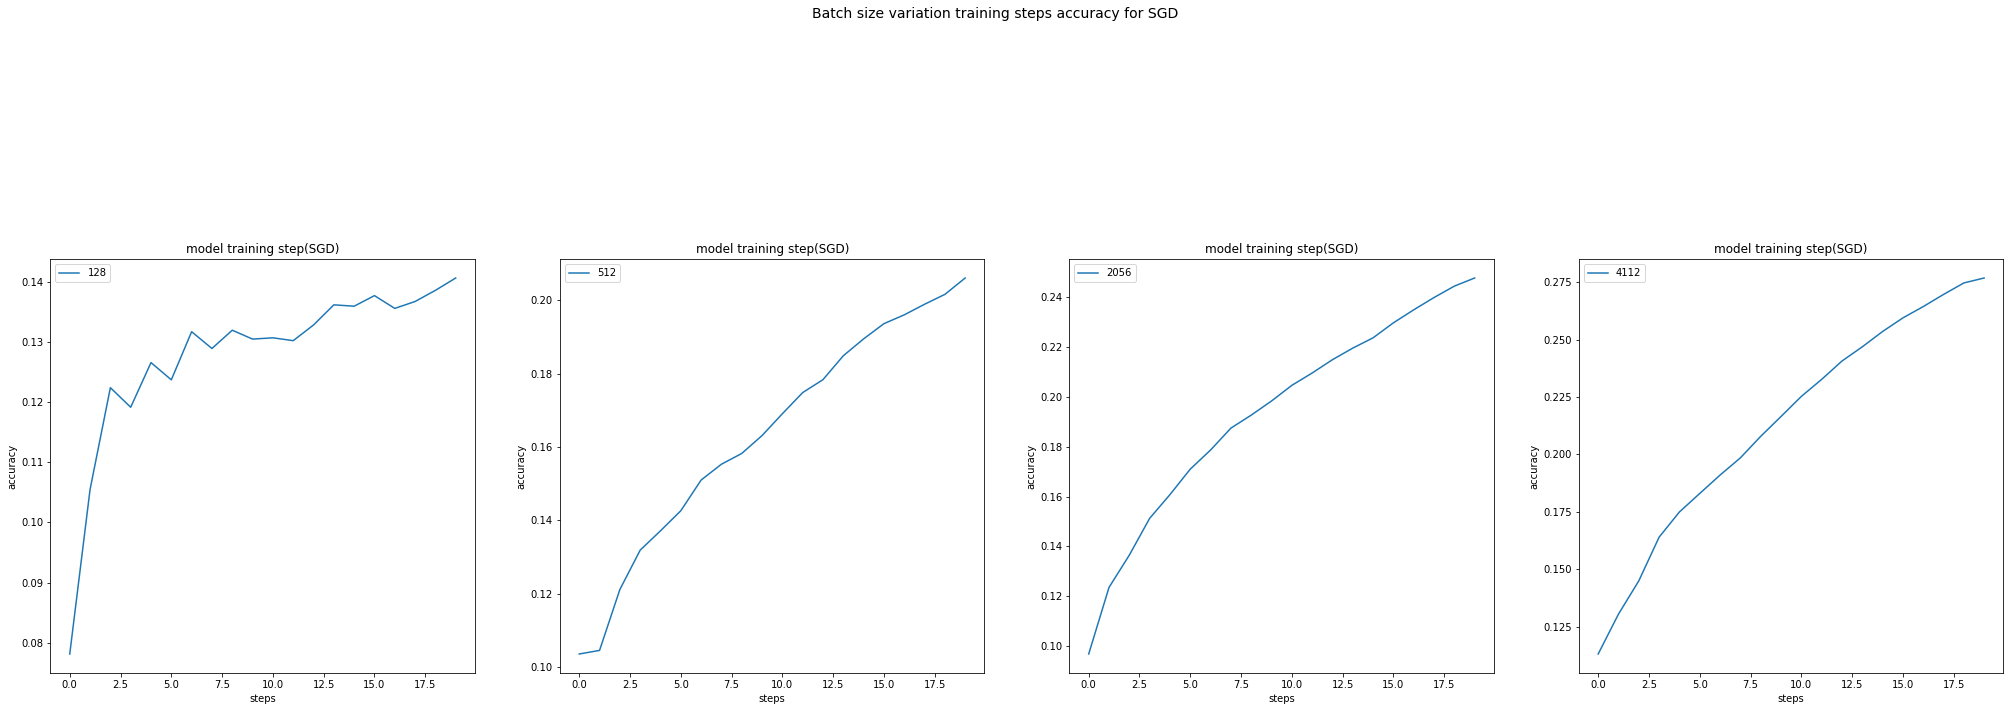

In [ ]:
plt.figure(figsize=(35,35))
plt.subplot(4,4,1)
plt.plot(sgd_BatchVary_step_acc[128][:20])
plt.title('model training step(SGD)')
plt.ylabel('accuracy')
plt.xlabel('steps')
plt.legend([128], loc='upper left')
plt.subplot(4,4,2)
plt.plot(sgd_BatchVary_step_acc[512][:20])
plt.title('model training step(SGD)')
plt.ylabel('accuracy')
plt.xlabel('steps')
plt.legend([512], loc='upper left')
plt.subplot(4,4,3)
plt.plot(sgd_BatchVary_step_acc[2056][:20])
plt.title('model training step(SGD)')
plt.ylabel('accuracy')
plt.xlabel('steps')
plt.legend([2056], loc='upper left')
plt.subplot(4,4,4)
plt.plot(sgd_BatchVary_step_acc[4112][:20])
plt.title('model training step(SGD)')
plt.ylabel('accuracy')
plt.xlabel('steps')
plt.legend([4112], loc='upper left')
plt.suptitle("Batch size variation training steps accuracy for SGD", fontsize=14)
plt.show()

#### Setting 4: Varying learning rate for Adam
* Optimizer : Adam
* Learning rate : [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
* Beta1, Beta2, epsilon : Default (Vanilla)
* Batchsize: 512
* epoch : 10

In [ ]:
adam_LRVary_History = {}
adam_LRVary_testResult = {}
for lRate in [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]:
  print("Training for learning rate: ", lRate)
  mymodel = createModel()
  opt = tf.optimizers.Adam( learning_rate=lRate)
  mymodel.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])
  adam_LRVary_History[lRate] = mymodel.fit(x=train_images, y=train_labels,batch_size=512, epochs=10, validation_split=0.2, verbose=0)
  print("Final training accuracy : {:.2f}".format(adam_LRVary_History[lRate].history['accuracy'][-1]*100))
  print("Final validation accuracy : {:.2f}".format(adam_LRVary_History[lRate].history['val_accuracy'][-1]*100))
  print("Final training loss : {:.2f}".format(adam_LRVary_History[lRate].history['loss'][-1]))
  print("Final validation loss : {:.2f}".format(adam_LRVary_History[lRate].history['val_loss'][-1]))
  test_loss, test_acc = mymodel.evaluate(test_images,  test_labels, verbose=2)
  print('Final test accuracy of this model : {:.2f}'.format(test_acc*100))
  adam_LRVary_testResult[lRate] = (test_loss, test_acc)

Training for learning rate:  0.001
Final training accuracy : 91.18
Final validation accuracy : 88.82
Final training loss : 0.37
Final validation loss : 0.44
313/313 - 1s - loss: 0.6521 - accuracy: 0.8274
Final test accuracy of this model : 82.74
Training for learning rate:  0.005
Final training accuracy : 83.33
Final validation accuracy : 79.74
Final training loss : 0.74
Final validation loss : 0.89
313/313 - 1s - loss: 1.0250 - accuracy: 0.7566
Final test accuracy of this model : 75.66
Training for learning rate:  0.01
Final training accuracy : 75.05
Final validation accuracy : 70.43
Final training loss : 1.15
Final validation loss : 1.29
313/313 - 1s - loss: 1.3812 - accuracy: 0.6840
Final test accuracy of this model : 68.40
Training for learning rate:  0.02
Final training accuracy : 58.82
Final validation accuracy : 46.51
Final training loss : 1.82
Final validation loss : 2.29
313/313 - 1s - loss: 2.3574 - accuracy: 0.4523
Final test accuracy of this model : 45.23
Training for learn

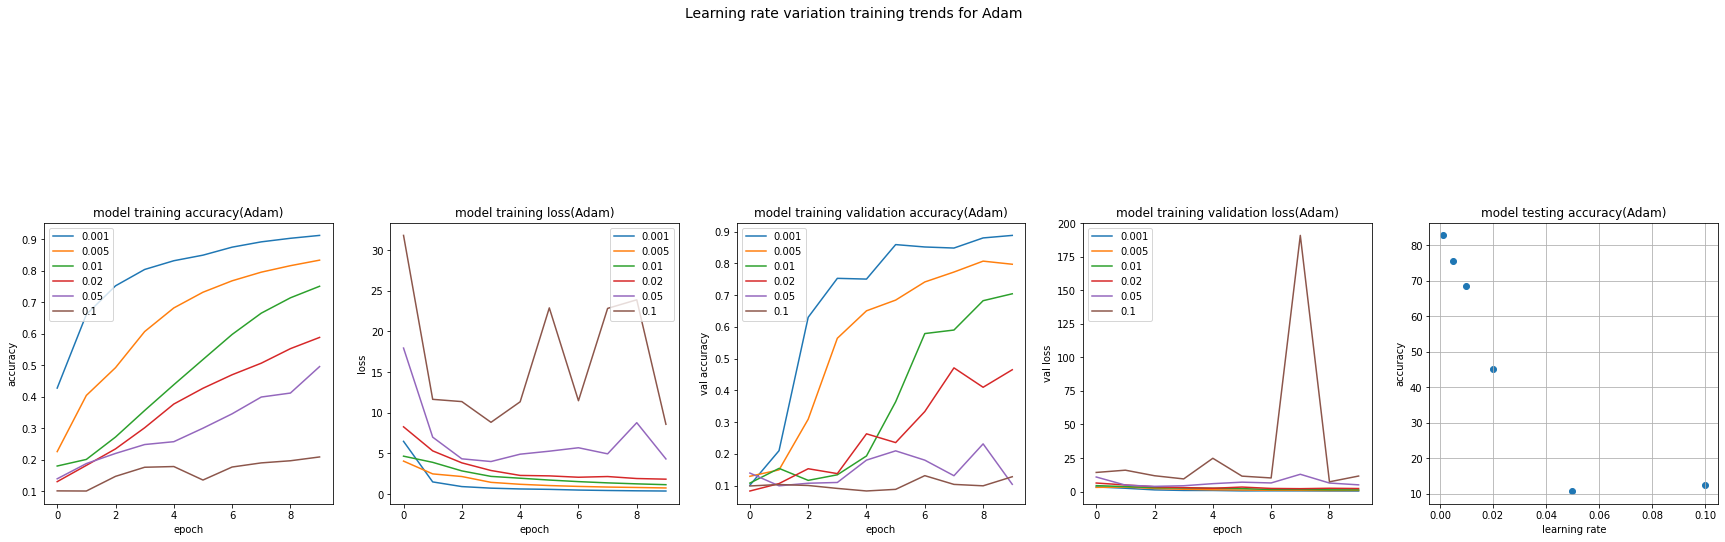

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.plot(adam_LRVary_History[0.001].history['accuracy'])
plt.plot(adam_LRVary_History[0.005].history['accuracy'])
plt.plot(adam_LRVary_History[0.01].history['accuracy'])
plt.plot(adam_LRVary_History[0.02].history['accuracy'])
plt.plot(adam_LRVary_History[0.05].history['accuracy'])
plt.plot(adam_LRVary_History[0.1].history['accuracy'])
plt.title('model training accuracy(Adam)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([0.001, 0.005, 0.01,0.02,0.05,0.1], loc='upper left')
plt.subplot(5,5,2)
plt.plot(adam_LRVary_History[0.001].history['loss'])
plt.plot(adam_LRVary_History[0.005].history['loss'])
plt.plot(adam_LRVary_History[0.01].history['loss'])
plt.plot(adam_LRVary_History[0.02].history['loss'])
plt.plot(adam_LRVary_History[0.05].history['loss'])
plt.plot(adam_LRVary_History[0.1].history['loss'])
plt.title('model training loss(Adam)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend([0.001, 0.005, 0.01,0.02,0.05,0.1], loc='upper right')
plt.subplot(5,5,3)
plt.plot(adam_LRVary_History[0.001].history['val_accuracy'])
plt.plot(adam_LRVary_History[0.005].history['val_accuracy'])
plt.plot(adam_LRVary_History[0.01].history['val_accuracy'])
plt.plot(adam_LRVary_History[0.02].history['val_accuracy'])
plt.plot(adam_LRVary_History[0.05].history['val_accuracy'])
plt.plot(adam_LRVary_History[0.1].history['val_accuracy'])
plt.title('model training validation accuracy(Adam)')
plt.ylabel('val accuracy')
plt.xlabel('epoch')
plt.legend([0.001, 0.005, 0.01,0.02,0.05,0.1], loc='upper left')
plt.subplot(5,5,4)
plt.plot(adam_LRVary_History[0.001].history['val_loss'])
plt.plot(adam_LRVary_History[0.005].history['val_loss'])
plt.plot(adam_LRVary_History[0.01].history['val_loss'])
plt.plot(adam_LRVary_History[0.02].history['val_loss'])
plt.plot(adam_LRVary_History[0.05].history['val_loss'])
plt.plot(adam_LRVary_History[0.1].history['val_loss'])
plt.title('model training validation loss(Adam)')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend([0.001, 0.005, 0.01,0.02,0.05,0.1], loc='upper left')
plt.suptitle("Learning rate variation training trends for Adam", fontsize=14)
plt.subplot(5,5,5)
plt.scatter([x for x in adam_LRVary_testResult.keys()], [round(y*100,2) for x,y in adam_LRVary_testResult.values()] )
plt.grid()
plt.title('model testing accuracy(Adam)')
plt.ylabel('accuracy')
plt.xlabel('learning rate')
plt.show()

#### Setting 5: Varying batch size for Adam
* Optimizer : Adam
* Learning rate : 0.001
* Beta1, Beta2, epsilon : Default (Vanilla)
* Batchsize: [128, 512, 2056, 4112]
* epoch : 5

In [ ]:
adam_BatchVary_History = {}
adam_BatchVary_testResult = {}
for batch in [128, 512, 2056, 4112]:
  print("##########################################")
  print("Training for batch size: ", batch)
  mymodel = createModel()
  opt = tf.optimizers.Adam( learning_rate=0.001)
  mymodel.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])
  adam_BatchVary_History[batch] = mymodel.fit(x=train_images, y=train_labels,batch_size=batch, epochs=5, validation_split=0.2, verbose=0)
  print("Final training accuracy : {:.2f}".format(adam_BatchVary_History[batch].history['accuracy'][-1]*100))
  print("Final validation accuracy : {:.2f}".format(adam_BatchVary_History[batch].history['val_accuracy'][-1]*100))
  print("Final training loss : {:.2f}".format(adam_BatchVary_History[batch].history['loss'][-1]))
  print("Final validation loss : {:.2f}".format(adam_BatchVary_History[batch].history['val_loss'][-1]))
  test_loss, test_acc = mymodel.evaluate(test_images,  test_labels, verbose=2)
  print('Final test accuracy of this model : {:.2f}'.format(test_acc*100))
  adam_BatchVary_testResult[batch] = (test_loss, test_acc)

##########################################
Training for batch size:  128
Final training accuracy : 83.81
Final validation accuracy : 83.63
Final training loss : 0.65
Final validation loss : 0.65
313/313 - 1s - loss: 0.7563 - accuracy: 0.7967
Final test accuracy of this model : 79.67
##########################################
Training for batch size:  512
Final training accuracy : 83.39
Final validation accuracy : 80.35
Final training loss : 0.62
Final validation loss : 0.71
313/313 - 1s - loss: 0.8216 - accuracy: 0.7607
Final test accuracy of this model : 76.07
##########################################
Training for batch size:  2056
Final training accuracy : 77.40
Final validation accuracy : 20.74
Final training loss : 0.86
Final validation loss : 2.66
313/313 - 1s - loss: 2.6570 - accuracy: 0.2032
Final test accuracy of this model : 20.32
##########################################
Training for batch size:  4112
Final training accuracy : 68.98
Final validation accuracy : 10.05
Final t

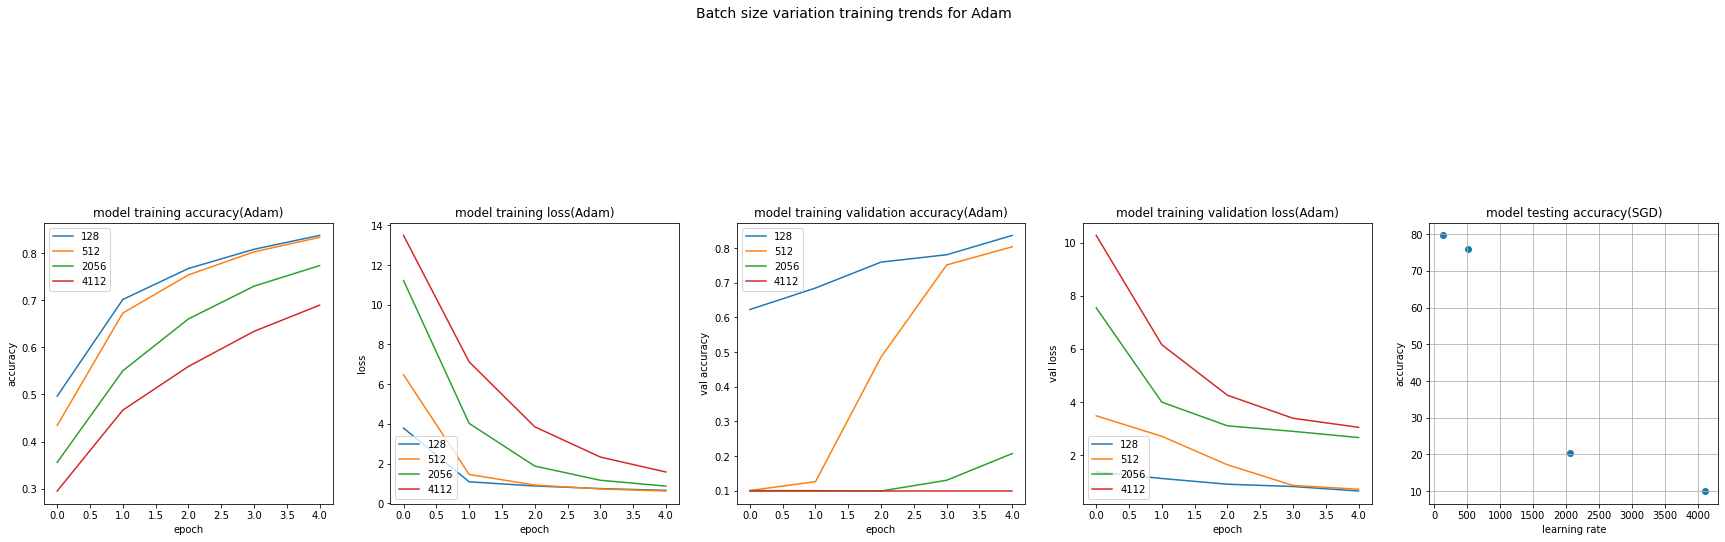

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.plot(adam_BatchVary_History[128].history['accuracy'])
plt.plot(adam_BatchVary_History[512].history['accuracy'])
plt.plot(adam_BatchVary_History[2056].history['accuracy'])
plt.plot(adam_BatchVary_History[4112].history['accuracy'])
plt.title('model training accuracy(Adam)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([128, 512, 2056, 4112], loc='upper left')
plt.subplot(5,5,2)
plt.plot(adam_BatchVary_History[128].history['loss'])
plt.plot(adam_BatchVary_History[512].history['loss'])
plt.plot(adam_BatchVary_History[2056].history['loss'])
plt.plot(adam_BatchVary_History[4112].history['loss'])
plt.title('model training loss(Adam)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend([128, 512, 2056, 4112], loc='lower left')
plt.subplot(5,5,3)
plt.plot(adam_BatchVary_History[128].history['val_accuracy'])
plt.plot(adam_BatchVary_History[512].history['val_accuracy'])
plt.plot(adam_BatchVary_History[2056].history['val_accuracy'])
plt.plot(adam_BatchVary_History[4112].history['val_accuracy'])
plt.title('model training validation accuracy(Adam)')
plt.ylabel('val accuracy')
plt.xlabel('epoch')
plt.legend([128, 512, 2056, 4112], loc='upper left')
plt.subplot(5,5,4)
plt.plot(adam_BatchVary_History[128].history['val_loss'])
plt.plot(adam_BatchVary_History[512].history['val_loss'])
plt.plot(adam_BatchVary_History[2056].history['val_loss'])
plt.plot(adam_BatchVary_History[4112].history['val_loss'])
plt.title('model training validation loss(Adam)')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend([128, 512, 2056, 4112], loc='lower left')
plt.suptitle("Batch size variation training trends for Adam", fontsize=14)
plt.subplot(5,5,5)
plt.scatter([x for x in adam_BatchVary_testResult.keys()], [round(y*100,2) for x,y in adam_BatchVary_testResult.values()] )
plt.grid()
plt.title('model testing accuracy(SGD)')
plt.ylabel('accuracy')
plt.xlabel('learning rate')
plt.show()

### Comparison and Analysis:
> As of now we have trained our model using SGD and ADAM optimizer using 5 separate settings. We have plotted several traning graphs to get insight about training process and impact of different hyper parameters. So what can we infer from those :


1.   (Figure 1)Given this model and CIFAR10 dataset, while training using SGD optimizer, we can see that the raning accuracy increases with higher training rate and training loss also decreased most when using higher learning rate(0.1). But in terms of validation accuracy the story is bit different. Higher the learning rate. although it is able to achive higher accuracy, but the training curve is having more perturbation compared to low learning rate. That means the stibility of training process becomes lower, showing huge fluctuations between epochs. And for validation loss with learning rate upto 0.05 the curve graually comes down, where as for learning rate as high as 0.1, we can clearly see an ```Elbow shape```  in the curve. After 5 epochs the curve almost flattens. Also when we plot the testing accuracy we can see the model can achieve significantly higher accuracy(71.8%) with learning rate 0.05 compared to learning rate 0.1(65.8%).



2.   (Figure 2)In next setting, when momentum is varied, its gives us a intuition about how fast the training converges. Following the theory, the model achieves 80% 
training accuracy after 4 epochs when 0.8 momentum is used. Where as with no momentum it just touches the mark with 10 epochs. This could a significant factor for very very deep, complex models. Also while testing highest accuracy is achieved while using momentum 0.8, after training with 10 epochs. This gives us intuition that with momentum the model can reach to the loss-weight curve minima faster. For validation loss curve, when training with higher momentum (0.8), it flattens after 3-4 epochs. Where as for training with no momentum the loss kept on decreasing till end of training.


3. (Figure 3)Varying the batch size from as low as 128 samples to as high 4112 samples per batch has shown two very interesting charecteristics. Models trained with batch sige 128 or 512, testing accuracy of the model is similar(73.6%) whereas when used higher batch size testing accuracy significantly decreased to ~13% for 2056 and 10% for 4112 batch size. This clearly shows that with higher batch size there is actually less number of updated in the model weight parameters, as a result it fails to reach the minima after certain number of epochs. That means the model needs to trained far longer with higher batch size. This also make the training process fall into a local minima. Also with batch size 128, only after 1-2 epochs the validation loss curve plateaued.


4. (Figure 4)In the same setting to visualize the step wise training process after each training batch, callback is used while training. When ploted the training accuracy for the first 20 steps for all four batch size, a interesting fact comes out. The curve with 128 batch size is more jumpy, as the accuracy keeps jumping back and forth where as over all trend of the curve is uprising. Higher the batch size, smoother the curve is.

5. Unlike SGD, learning rate variation experiment with Adam optimizer shows opposite result. The model achieves highest training, validation and testing accuracy when the learning rate is lowest 0.001. And interestingly the training becomes worse, and very much unstable with increasing learning rate. With learning rate 0.1, the model shows mere ~12% accuracy when tested. Also the training loss curve and alidation loss curve shows typical jumpy behavior with higher learning rate and with increasing epochs. ```If we compare SGD with Adam, we can clearly see that Adam optimizer is able to achive higher accuracy(82.74%) with same model in comparison to SGD in its best setting(81%). Also Adam is faster. The model with Adam optimizer and 0.001 learning rate converges just after 1 epoch, where as it takes 4 epochs for SGD.``` This is a huge improvement when the model is very complex and dataset is extremely huge.




#### What if we keep on traing for long? in other words whats the impact of number of epoch as hyper parameter?

In [ ]:
adam_EpochVary_acc = []
adam_EpochVary_val_acc = []
adam_EpochVary_test_acc = []
mymodel = createModel()
opt = tf.optimizers.Adam( learning_rate=0.001)
mymodel.compile(optimizer=opt,
            loss='sparse_categorical_crossentropy', 
            metrics=['accuracy'])
for epoch in range(40):
  print("Epoch : ",epoch+1) 
  history = mymodel.fit(x=train_images, y=train_labels,batch_size=128, epochs=1, validation_split=0.2, verbose=0)
  adam_EpochVary_acc.append(history.history['accuracy'][-1]*100)
  adam_EpochVary_val_acc.append(history.history['val_accuracy'][-1]*100)
  test_loss, test_acc = mymodel.evaluate(test_images,  test_labels, verbose=2)
  print('Final test accuracy of this model : {:.2f}'.format(test_acc*100))
  adam_EpochVary_test_acc.append(test_acc*100)
  print("------------------------------------------")

Epoch :  1
313/313 - 1s - loss: 1.6161 - accuracy: 0.5376
Final test accuracy of this model : 53.76
------------------------------------------
Epoch :  2
313/313 - 1s - loss: 1.2366 - accuracy: 0.6522
Final test accuracy of this model : 65.22
------------------------------------------
Epoch :  3
313/313 - 1s - loss: 0.9668 - accuracy: 0.7302
Final test accuracy of this model : 73.02
------------------------------------------
Epoch :  4
313/313 - 1s - loss: 0.8997 - accuracy: 0.7570
Final test accuracy of this model : 75.70
------------------------------------------
Epoch :  5
313/313 - 1s - loss: 0.7930 - accuracy: 0.7946
Final test accuracy of this model : 79.46
------------------------------------------
Epoch :  6
313/313 - 1s - loss: 0.7393 - accuracy: 0.8101
Final test accuracy of this model : 81.01
------------------------------------------
Epoch :  7
313/313 - 1s - loss: 0.7792 - accuracy: 0.8014
Final test accuracy of this model : 80.14
------------------------------------------

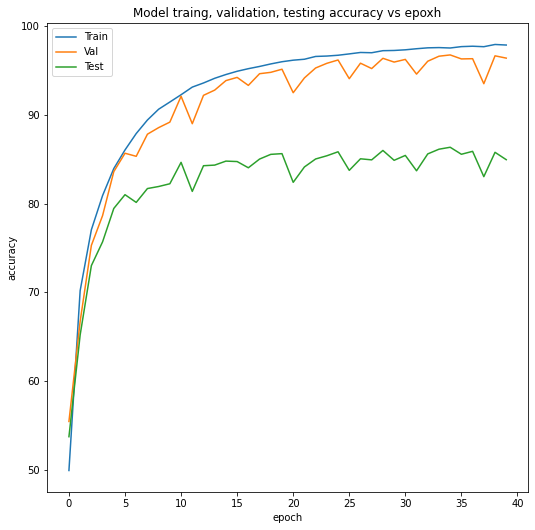

In [ ]:
plt.figure(figsize=(50,50))
plt.subplot(5,5,4)
plt.plot(adam_EpochVary_acc )
plt.plot(adam_EpochVary_val_acc )
plt.plot(adam_EpochVary_test_acc )
plt.title('Model traing, validation, testing accuracy vs epoxh')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val', 'Test'], loc='upper left')
plt.show()

> This experiment shows that even though we keep on training longer, the test accuracy of the model becomes jumpy around certain valu(83%-85%), although overall trend remains flat. With higher epoch the training accuracy first jumps sharply then keeps on improving very slowly. But the validation accuracy and test accuracy flattens. And finally after training for 40 epochs when the traing accuracy goes around 95%, there is a huge gap between training accuracy and testing accuracy(85%). This indicates that the model has overfitted with training data and the accuracy gap indicates the varience of the model. 



---



#### What's next?

##### Will the training trend and analysis remain same for another model(simpler) and dataset(simpler)?

In [ ]:
def createSimpleModel():
  layer_list = [tf.keras.layers.Conv2D(64, (6,6), activation='relu', input_shape = (28,28,1)),tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
              tf.keras.layers.MaxPool2D((2,2),strides = 1, padding = 'valid'),tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(128, activation=tf.nn.relu),
              tf.keras.layers.Dense(64, activation=tf.nn.relu), tf.keras.layers.Dense(10,activation=tf.nn.softmax)]
  return  tf.keras.Sequential(layer_list)

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Printing the shape for trainining and testing dataset
print("Training images data shape is : {}".format(x_train.shape))
print("Training labels data shape is : {}".format(y_train.shape))
print("Test images data shape is : {}".format(x_test.shape))
print("Test images data shape is : {}".format(y_test.shape))

Training images data shape is : (60000, 28, 28)
Training labels data shape is : (60000,)
Test images data shape is : (10000, 28, 28)
Test images data shape is : (10000,)


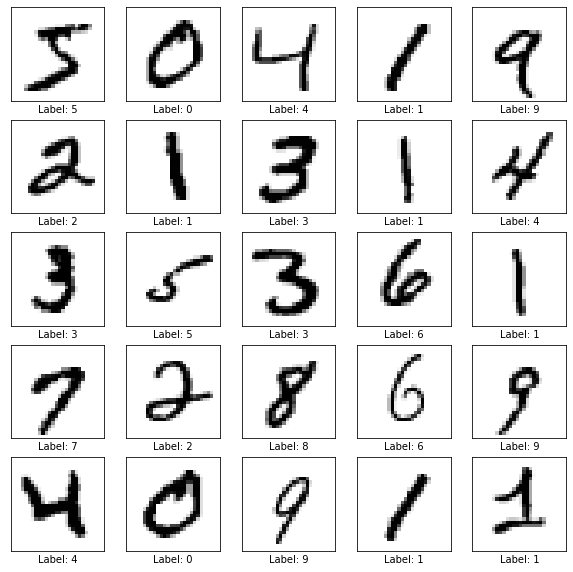

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel("Label: {}".format(y_train[i]))
plt.show()

In [ ]:
x_train = x_train.reshape([-1, 28, 28, 1]).astype(np.float32) / 255
x_test = x_test.reshape([-1, 28,28, 1]).astype(np.float32) / 255
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

#### Setting 1: Varying learning rate for SGD
* Optimizer : SGD
* Learning rate : [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
* Momentum : Default (Vanilla)
* Batchsize: 512
* epoch : 10

In [ ]:
sgd_LRVary_History = {}
sgd_LRVary_testResult = {}
for lRate in [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]:
  print("Training for learning rate: ", lRate)
  mysimplemodel = createSimpleModel()
  opt = tf.optimizers.SGD( learning_rate=lRate)
  mysimplemodel.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])
  sgd_LRVary_History[lRate] = mysimplemodel.fit(x=x_train, y=y_train,batch_size=512, epochs=10, validation_split=0.2, verbose=0)
  print("Final training accuracy : {:.2f}".format(sgd_LRVary_History[lRate].history['accuracy'][-1]*100))
  print("Final validation accuracy : {:.2f}".format(sgd_LRVary_History[lRate].history['val_accuracy'][-1]*100))
  print("Final training loss : {:.2f}".format(sgd_LRVary_History[lRate].history['loss'][-1]))
  print("Final validation loss : {:.2f}".format(sgd_LRVary_History[lRate].history['val_loss'][-1]))
  test_loss, test_acc = mysimplemodel.evaluate(x_test,  y_test, verbose=2)
  print('Final test accuracy of this model : {:.2f}'.format(test_acc*100))
  sgd_LRVary_testResult[lRate] = (test_loss, test_acc)
  print("#####################################")

Training for learning rate:  0.001
Final training accuracy : 83.01
Final validation accuracy : 85.43
Final training loss : 0.67
Final validation loss : 0.58
313/313 - 1s - loss: 0.5816 - accuracy: 0.8532
Final test accuracy of this model : 85.32
#####################################
Training for learning rate:  0.005
Final training accuracy : 92.69
Final validation accuracy : 93.31
Final training loss : 0.25
Final validation loss : 0.23
313/313 - 1s - loss: 0.2339 - accuracy: 0.9311
Final test accuracy of this model : 93.11
#####################################
Training for learning rate:  0.01
Final training accuracy : 94.60
Final validation accuracy : 95.03
Final training loss : 0.18
Final validation loss : 0.17
313/313 - 1s - loss: 0.1629 - accuracy: 0.9512
Final test accuracy of this model : 95.12
#####################################
Training for learning rate:  0.02
Final training accuracy : 96.71
Final validation accuracy : 97.03
Final training loss : 0.11
Final validation loss 

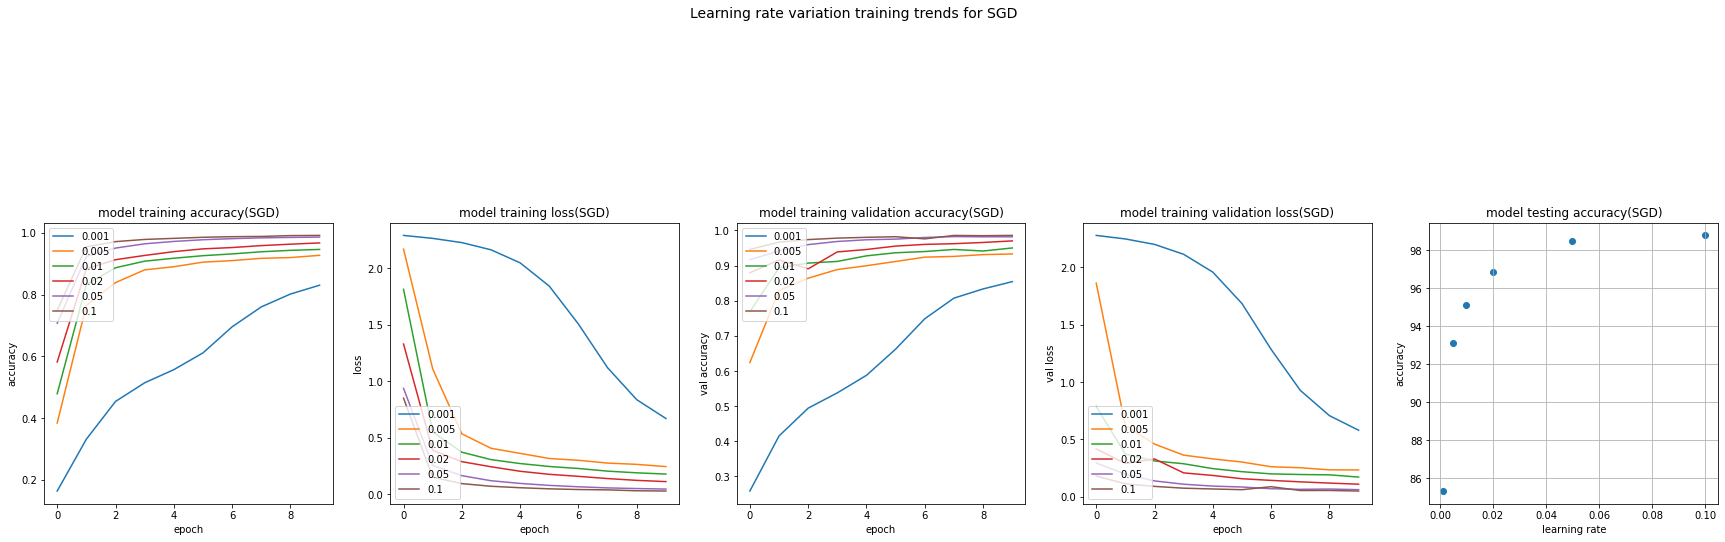

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.plot(sgd_LRVary_History[0.001].history['accuracy'])
plt.plot(sgd_LRVary_History[0.005].history['accuracy'])
plt.plot(sgd_LRVary_History[0.01].history['accuracy'])
plt.plot(sgd_LRVary_History[0.02].history['accuracy'])
plt.plot(sgd_LRVary_History[0.05].history['accuracy'])
plt.plot(sgd_LRVary_History[0.1].history['accuracy'])
plt.title('model training accuracy(SGD)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([0.001, 0.005, 0.01,0.02,0.05,0.1], loc='upper left')
plt.subplot(5,5,2)
plt.plot(sgd_LRVary_History[0.001].history['loss'])
plt.plot(sgd_LRVary_History[0.005].history['loss'])
plt.plot(sgd_LRVary_History[0.01].history['loss'])
plt.plot(sgd_LRVary_History[0.02].history['loss'])
plt.plot(sgd_LRVary_History[0.05].history['loss'])
plt.plot(sgd_LRVary_History[0.1].history['loss'])
plt.title('model training loss(SGD)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend([0.001, 0.005, 0.01,0.02,0.05,0.1], loc='lower left')
plt.subplot(5,5,3)
plt.plot(sgd_LRVary_History[0.001].history['val_accuracy'])
plt.plot(sgd_LRVary_History[0.005].history['val_accuracy'])
plt.plot(sgd_LRVary_History[0.01].history['val_accuracy'])
plt.plot(sgd_LRVary_History[0.02].history['val_accuracy'])
plt.plot(sgd_LRVary_History[0.05].history['val_accuracy'])
plt.plot(sgd_LRVary_History[0.1].history['val_accuracy'])
plt.title('model training validation accuracy(SGD)')
plt.ylabel('val accuracy')
plt.xlabel('epoch')
plt.legend([0.001, 0.005, 0.01,0.02,0.05,0.1], loc='upper left')
plt.subplot(5,5,4)
plt.plot(sgd_LRVary_History[0.001].history['val_loss'])
plt.plot(sgd_LRVary_History[0.005].history['val_loss'])
plt.plot(sgd_LRVary_History[0.01].history['val_loss'])
plt.plot(sgd_LRVary_History[0.02].history['val_loss'])
plt.plot(sgd_LRVary_History[0.05].history['val_loss'])
plt.plot(sgd_LRVary_History[0.1].history['val_loss'])
plt.title('model training validation loss(SGD)')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend([0.001, 0.005, 0.01,0.02,0.05,0.1], loc='lower left')
plt.suptitle("Learning rate variation training trends for SGD", fontsize=14)
plt.subplot(5,5,5)
plt.scatter([x for x in sgd_LRVary_testResult.keys()], [round(y*100,2) for x,y in sgd_LRVary_testResult.values()] )
plt.grid()
plt.title('model testing accuracy(SGD)')
plt.ylabel('accuracy')
plt.xlabel('learning rate')
plt.show()

#### Setting 2: Varying momentum for SGD
* Optimizer : SGD
* Learning rate : 0.001
* Momentum : [0,0.2,0.5,0.6,0.7,0.8]
* Batchsize: 512
* epoch : 10

In [ ]:
sgd_MmtVary_History = {}
sgd_MmtVary_testResult = {}
for mmt in [0,0.2,0.5,0.6,0.7,0.8]:
  print("##########################################")
  print("Traing for momentum: ", mmt)
  mysimplemodel = createSimpleModel()
  opt = tf.optimizers.SGD( learning_rate=0.001, momentum=mmt)
  mysimplemodel.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])
  sgd_MmtVary_History[mmt] = mysimplemodel.fit(x=x_train, y=y_train,batch_size=512, epochs=10, validation_split=0.2, verbose=0)
  print("Final training accuracy : {:.2f}".format(sgd_MmtVary_History[mmt].history['accuracy'][-1]*100))
  print("Final validation accuracy : {:.2f}".format(sgd_MmtVary_History[mmt].history['val_accuracy'][-1]*100))
  print("Final training loss : {:.2f}".format(sgd_MmtVary_History[mmt].history['loss'][-1]))
  print("Final validation loss : {:.2f}".format(sgd_MmtVary_History[mmt].history['val_loss'][-1]))
  test_loss, test_acc = mysimplemodel.evaluate(x_test,  y_test, verbose=2)
  print('Final test accuracy of this model : {:.2f}'.format(test_acc*100))
  sgd_MmtVary_testResult[mmt] = (test_loss, test_acc)

##########################################
Traing for momentum:  0
Final training accuracy : 83.99
Final validation accuracy : 85.79
Final training loss : 0.61
Final validation loss : 0.54
313/313 - 1s - loss: 0.5396 - accuracy: 0.8586
Final test accuracy of this model : 85.86
##########################################
Traing for momentum:  0.2
Final training accuracy : 85.72
Final validation accuracy : 87.52
Final training loss : 0.53
Final validation loss : 0.46
313/313 - 1s - loss: 0.4740 - accuracy: 0.8734
Final test accuracy of this model : 87.34
##########################################
Traing for momentum:  0.5
Final training accuracy : 89.60
Final validation accuracy : 90.90
Final training loss : 0.36
Final validation loss : 0.33
313/313 - 1s - loss: 0.3304 - accuracy: 0.9075
Final test accuracy of this model : 90.75
##########################################
Traing for momentum:  0.6
Final training accuracy : 91.22
Final validation accuracy : 92.18
Final training loss : 0.30


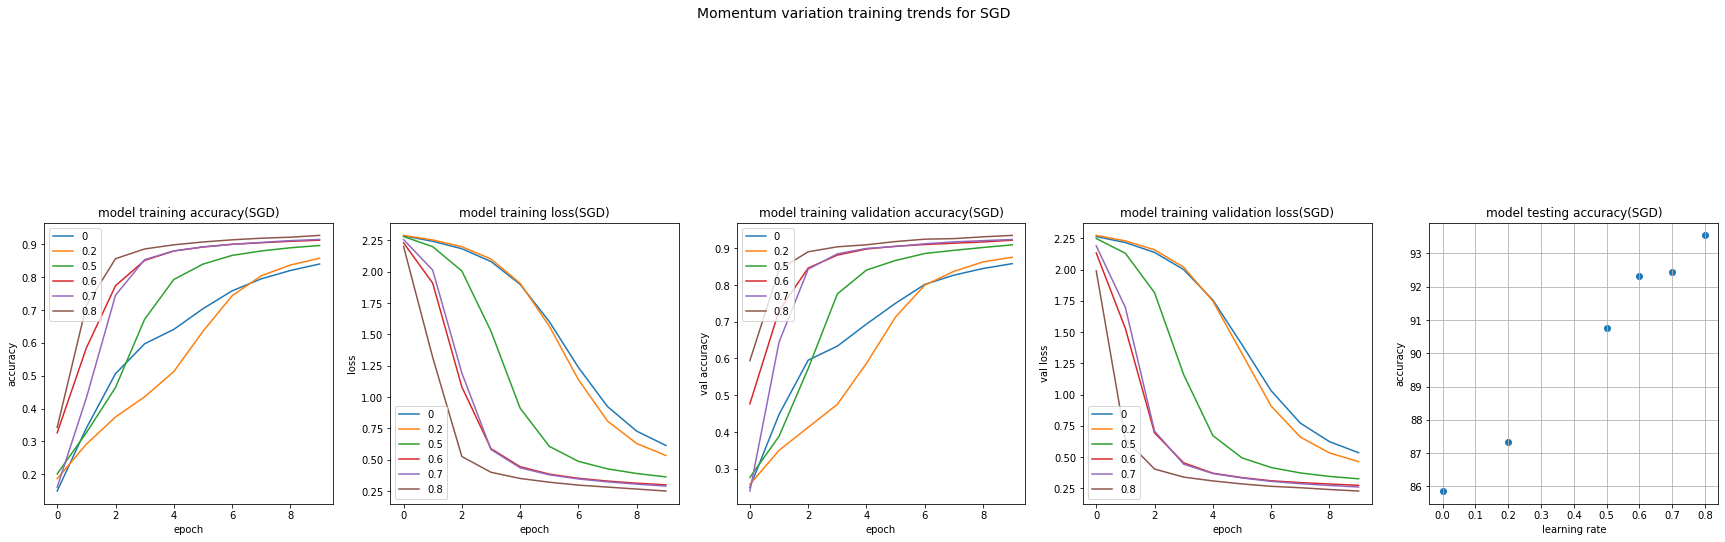

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.plot(sgd_MmtVary_History[0].history['accuracy'])
plt.plot(sgd_MmtVary_History[0.2].history['accuracy'])
plt.plot(sgd_MmtVary_History[0.5].history['accuracy'])
plt.plot(sgd_MmtVary_History[0.6].history['accuracy'])
plt.plot(sgd_MmtVary_History[0.7].history['accuracy'])
plt.plot(sgd_MmtVary_History[0.8].history['accuracy'])
plt.title('model training accuracy(SGD)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([0,0.2,0.5,0.6,0.7,0.8], loc='upper left')
plt.subplot(5,5,2)
plt.plot(sgd_MmtVary_History[0].history['loss'])
plt.plot(sgd_MmtVary_History[0.2].history['loss'])
plt.plot(sgd_MmtVary_History[0.5].history['loss'])
plt.plot(sgd_MmtVary_History[0.6].history['loss'])
plt.plot(sgd_MmtVary_History[0.7].history['loss'])
plt.plot(sgd_MmtVary_History[0.8].history['loss'])
plt.title('model training loss(SGD)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend([0,0.2,0.5,0.6,0.7,0.8], loc='lower left')
plt.subplot(5,5,3)
plt.plot(sgd_MmtVary_History[0].history['val_accuracy'])
plt.plot(sgd_MmtVary_History[0.2].history['val_accuracy'])
plt.plot(sgd_MmtVary_History[0.5].history['val_accuracy'])
plt.plot(sgd_MmtVary_History[0.6].history['val_accuracy'])
plt.plot(sgd_MmtVary_History[0.7].history['val_accuracy'])
plt.plot(sgd_MmtVary_History[0.8].history['val_accuracy'])
plt.title('model training validation accuracy(SGD)')
plt.ylabel('val accuracy')
plt.xlabel('epoch')
plt.legend([0,0.2,0.5,0.6,0.7,0.8], loc='upper left')
plt.subplot(5,5,4)
plt.plot(sgd_MmtVary_History[0].history['val_loss'])
plt.plot(sgd_MmtVary_History[0.2].history['val_loss'])
plt.plot(sgd_MmtVary_History[0.5].history['val_loss'])
plt.plot(sgd_MmtVary_History[0.6].history['val_loss'])
plt.plot(sgd_MmtVary_History[0.7].history['val_loss'])
plt.plot(sgd_MmtVary_History[0.8].history['val_loss'])
plt.title('model training validation loss(SGD)')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend([0,0.2,0.5,0.6,0.7,0.8], loc='lower left')
plt.suptitle("Momentum variation training trends for SGD", fontsize=14)
plt.subplot(5,5,5)
plt.scatter([x for x in sgd_MmtVary_testResult.keys()], [round(y*100,2) for x,y in sgd_MmtVary_testResult.values()] )
plt.grid()
plt.title('model testing accuracy(SGD)')
plt.ylabel('accuracy')
plt.xlabel('learning rate')
plt.show()

#### Setting 3: Varying batch size for SGD
* Optimizer : SGD
* Learning rate : 0.001
* Momentum : 0.8
* Batchsize: [128, 512, 2056, 4112] 
* epoch : 5

In [ ]:
sgd_BatchVary_History = {}
sgd_BatchVary_testResult = {}
for batch in [128, 512, 2056, 4112]:
  losses = []
  accuracy = []
  print("##########################################")
  print("Training for batch size: ", batch)
  mysimplemodel = createSimpleModel()
  opt = tf.optimizers.SGD( learning_rate=0.001, momentum=0.8)
  mysimplemodel.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])
  sgd_BatchVary_History[batch] = mysimplemodel.fit(x=x_train, y=y_train,batch_size=batch, epochs=5, validation_split=0.2, verbose=0)
  print("Final training accuracy : {:.2f}".format(sgd_BatchVary_History[batch].history['accuracy'][-1]*100))
  print("Final validation accuracy : {:.2f}".format(sgd_BatchVary_History[batch].history['val_accuracy'][-1]*100))
  print("Final training loss : {:.2f}".format(sgd_BatchVary_History[batch].history['loss'][-1]))
  print("Final validation loss : {:.2f}".format(sgd_BatchVary_History[batch].history['val_loss'][-1]))
  test_loss, test_acc = mysimplemodel.evaluate(x_test,  y_test, verbose=2)
  print('Final test accuracy of this model : {:.2f}'.format(test_acc*100))
  sgd_BatchVary_testResult[batch] = (test_loss, test_acc)

##########################################
Training for batch size:  128
Final training accuracy : 94.58
Final validation accuracy : 95.63
Final training loss : 0.18
Final validation loss : 0.16
313/313 - 1s - loss: 0.1510 - accuracy: 0.9570
Final test accuracy of this model : 95.70
##########################################
Training for batch size:  512
Final training accuracy : 90.15
Final validation accuracy : 91.46
Final training loss : 0.34
Final validation loss : 0.30
313/313 - 1s - loss: 0.3034 - accuracy: 0.9125
Final test accuracy of this model : 91.25
##########################################
Training for batch size:  2056
Final training accuracy : 63.67
Final validation accuracy : 68.39
Final training loss : 1.93
Final validation loss : 1.77
313/313 - 1s - loss: 1.7649 - accuracy: 0.6790
Final test accuracy of this model : 67.90
##########################################
Training for batch size:  4112
Final training accuracy : 43.66
Final validation accuracy : 46.12
Final t

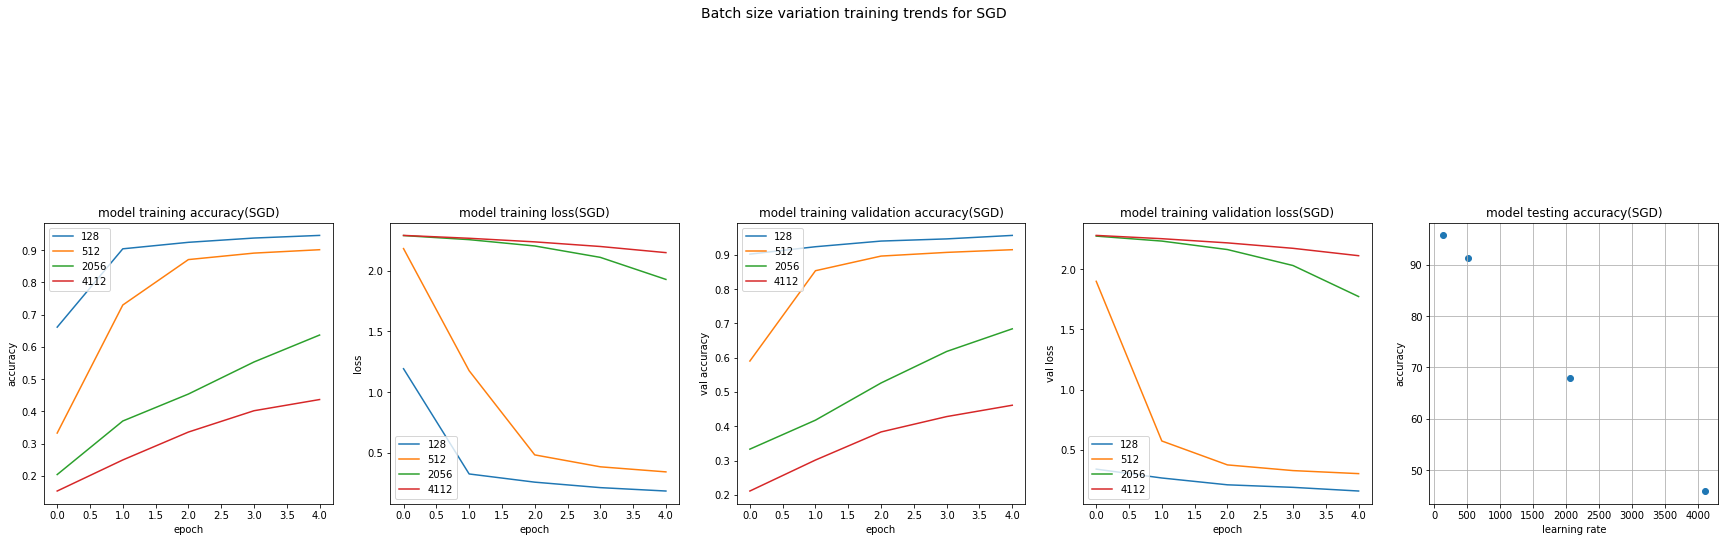

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.plot(sgd_BatchVary_History[128].history['accuracy'])
plt.plot(sgd_BatchVary_History[512].history['accuracy'])
plt.plot(sgd_BatchVary_History[2056].history['accuracy'])
plt.plot(sgd_BatchVary_History[4112].history['accuracy'])
plt.title('model training accuracy(SGD)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([128, 512, 2056, 4112], loc='upper left')
plt.subplot(5,5,2)
plt.plot(sgd_BatchVary_History[128].history['loss'])
plt.plot(sgd_BatchVary_History[512].history['loss'])
plt.plot(sgd_BatchVary_History[2056].history['loss'])
plt.plot(sgd_BatchVary_History[4112].history['loss'])
plt.title('model training loss(SGD)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend([128, 512, 2056, 4112], loc='lower left')
plt.subplot(5,5,3)
plt.plot(sgd_BatchVary_History[128].history['val_accuracy'])
plt.plot(sgd_BatchVary_History[512].history['val_accuracy'])
plt.plot(sgd_BatchVary_History[2056].history['val_accuracy'])
plt.plot(sgd_BatchVary_History[4112].history['val_accuracy'])
plt.title('model training validation accuracy(SGD)')
plt.ylabel('val accuracy')
plt.xlabel('epoch')
plt.legend([128, 512, 2056, 4112], loc='upper left')
plt.subplot(5,5,4)
plt.plot(sgd_BatchVary_History[128].history['val_loss'])
plt.plot(sgd_BatchVary_History[512].history['val_loss'])
plt.plot(sgd_BatchVary_History[2056].history['val_loss'])
plt.plot(sgd_BatchVary_History[4112].history['val_loss'])
plt.title('model training validation loss(SGD)')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend([128, 512, 2056, 4112], loc='lower left')
plt.suptitle("Batch size variation training trends for SGD", fontsize=14)
plt.subplot(5,5,5)
plt.scatter([x for x in sgd_BatchVary_testResult.keys()], [round(y*100,2) for x,y in sgd_BatchVary_testResult.values()] )
plt.grid()
plt.title('model testing accuracy(SGD)')
plt.ylabel('accuracy')
plt.xlabel('learning rate')
plt.show()

#### Setting 4: Varying learning rate for Adam
* Optimizer : Adam
* Learning rate : [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
* Beta1, Beta2, epsilon : Default (Vanilla)
* Batchsize: 512
* epoch : 10

In [ ]:
adam_LRVary_History = {}
adam_LRVary_testResult = {}
for lRate in [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]:
  print("Training for learning rate: ", lRate)
  mysimplemodel = createSimpleModel()
  opt = tf.optimizers.Adam( learning_rate=lRate)
  mysimplemodel.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])
  adam_LRVary_History[lRate] = mysimplemodel.fit(x=x_train, y=y_train,batch_size=512, epochs=10, validation_split=0.2, verbose=0)
  print("Final training accuracy : {:.2f}".format(adam_LRVary_History[lRate].history['accuracy'][-1]*100))
  print("Final validation accuracy : {:.2f}".format(adam_LRVary_History[lRate].history['val_accuracy'][-1]*100))
  print("Final training loss : {:.2f}".format(adam_LRVary_History[lRate].history['loss'][-1]))
  print("Final validation loss : {:.2f}".format(adam_LRVary_History[lRate].history['val_loss'][-1]))
  test_loss, test_acc = mysimplemodel.evaluate(x_test,  y_test, verbose=2)
  print('Final test accuracy of this model : {:.2f}'.format(test_acc*100))
  adam_LRVary_testResult[lRate] = (test_loss, test_acc)

Training for learning rate:  0.001
Final training accuracy : 99.86
Final validation accuracy : 99.10
Final training loss : 0.00
Final validation loss : 0.04
313/313 - 1s - loss: 0.0325 - accuracy: 0.9908
Final test accuracy of this model : 99.08
Training for learning rate:  0.005
Final training accuracy : 98.63
Final validation accuracy : 97.63
Final training loss : 0.04
Final validation loss : 0.08
313/313 - 1s - loss: 0.0797 - accuracy: 0.9767
Final test accuracy of this model : 97.67
Training for learning rate:  0.01
Final training accuracy : 99.27
Final validation accuracy : 98.33
Final training loss : 0.02
Final validation loss : 0.08
313/313 - 1s - loss: 0.0673 - accuracy: 0.9823
Final test accuracy of this model : 98.23
Training for learning rate:  0.02
Final training accuracy : 98.83
Final validation accuracy : 97.95
Final training loss : 0.04
Final validation loss : 0.11
313/313 - 1s - loss: 0.0993 - accuracy: 0.9782
Final test accuracy of this model : 97.82
Training for learn

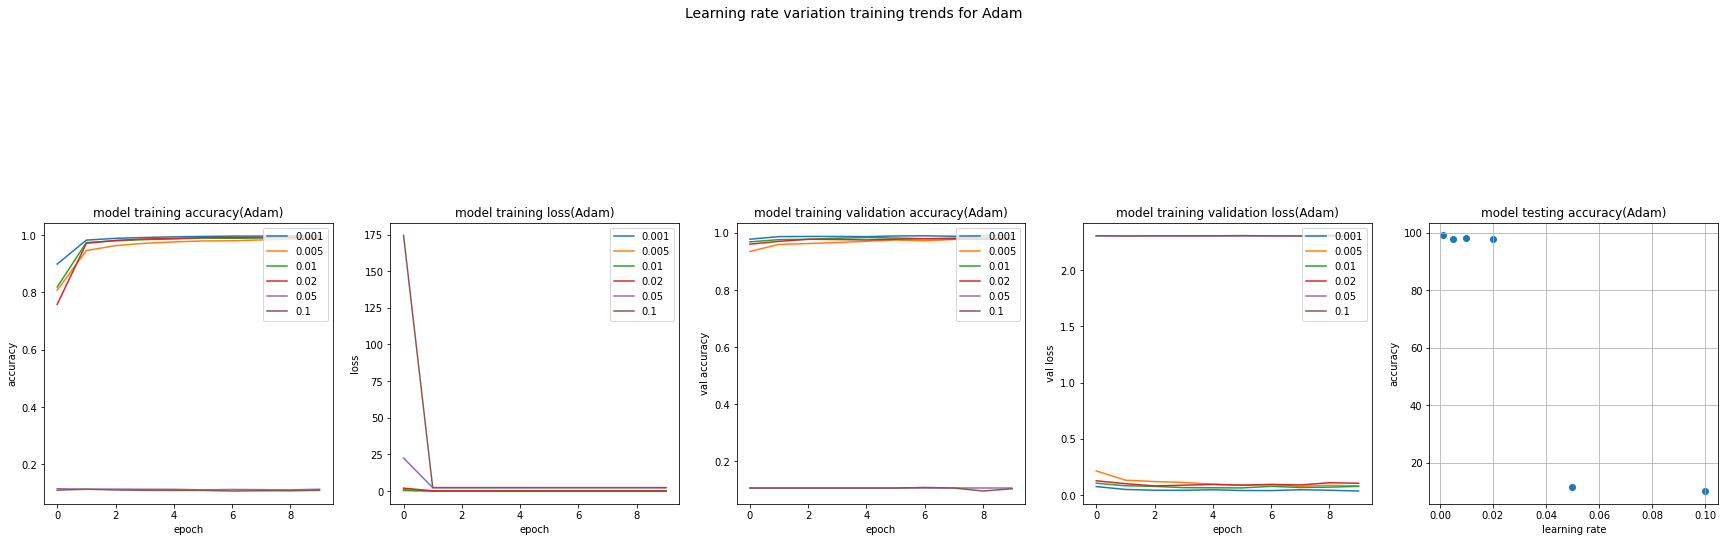

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.plot(adam_LRVary_History[0.001].history['accuracy'])
plt.plot(adam_LRVary_History[0.005].history['accuracy'])
plt.plot(adam_LRVary_History[0.01].history['accuracy'])
plt.plot(adam_LRVary_History[0.02].history['accuracy'])
plt.plot(adam_LRVary_History[0.05].history['accuracy'])
plt.plot(adam_LRVary_History[0.1].history['accuracy'])
plt.title('model training accuracy(Adam)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([0.001, 0.005, 0.01,0.02,0.05,0.1], loc='upper right')
plt.subplot(5,5,2)
plt.plot(adam_LRVary_History[0.001].history['loss'])
plt.plot(adam_LRVary_History[0.005].history['loss'])
plt.plot(adam_LRVary_History[0.01].history['loss'])
plt.plot(adam_LRVary_History[0.02].history['loss'])
plt.plot(adam_LRVary_History[0.05].history['loss'])
plt.plot(adam_LRVary_History[0.1].history['loss'])
plt.title('model training loss(Adam)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend([0.001, 0.005, 0.01,0.02,0.05,0.1], loc='upper right')
plt.subplot(5,5,3)
plt.plot(adam_LRVary_History[0.001].history['val_accuracy'])
plt.plot(adam_LRVary_History[0.005].history['val_accuracy'])
plt.plot(adam_LRVary_History[0.01].history['val_accuracy'])
plt.plot(adam_LRVary_History[0.02].history['val_accuracy'])
plt.plot(adam_LRVary_History[0.05].history['val_accuracy'])
plt.plot(adam_LRVary_History[0.1].history['val_accuracy'])
plt.title('model training validation accuracy(Adam)')
plt.ylabel('val accuracy')
plt.xlabel('epoch')
plt.legend([0.001, 0.005, 0.01,0.02,0.05,0.1], loc='upper right')
plt.subplot(5,5,4)
plt.plot(adam_LRVary_History[0.001].history['val_loss'])
plt.plot(adam_LRVary_History[0.005].history['val_loss'])
plt.plot(adam_LRVary_History[0.01].history['val_loss'])
plt.plot(adam_LRVary_History[0.02].history['val_loss'])
plt.plot(adam_LRVary_History[0.05].history['val_loss'])
plt.plot(adam_LRVary_History[0.1].history['val_loss'])
plt.title('model training validation loss(Adam)')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend([0.001, 0.005, 0.01,0.02,0.05,0.1], loc='upper right')
plt.suptitle("Learning rate variation training trends for Adam", fontsize=14)
plt.subplot(5,5,5)
plt.scatter([x for x in adam_LRVary_testResult.keys()], [round(y*100,2) for x,y in adam_LRVary_testResult.values()] )
plt.grid()
plt.title('model testing accuracy(Adam)')
plt.ylabel('accuracy')
plt.xlabel('learning rate')
plt.show()

#### Setting 5: Varying batch size for Adam
* Optimizer : Adam
* Learning rate : 0.01
* Beta1, Beta2, epsilon : Default (Vanilla)
* Batchsize: [128, 512, 2056, 4112]
* epoch : 5

In [ ]:
adam_BatchVary_History = {}
adam_BatchVary_testResult = {}
for batch in [128, 512, 2056, 4112]:
  print("##########################################")
  print("Training for batch size: ", batch)
  mysimplemodel = createSimpleModel()
  opt = tf.optimizers.Adam( learning_rate=0.01)
  mysimplemodel.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])
  adam_BatchVary_History[batch] = mysimplemodel.fit(x=x_train, y=y_train,batch_size=batch, epochs=5, validation_split=0.2, verbose=0)
  print("Final training accuracy : {:.2f}".format(adam_BatchVary_History[batch].history['accuracy'][-1]*100))
  print("Final validation accuracy : {:.2f}".format(adam_BatchVary_History[batch].history['val_accuracy'][-1]*100))
  print("Final training loss : {:.2f}".format(adam_BatchVary_History[batch].history['loss'][-1]))
  print("Final validation loss : {:.2f}".format(adam_BatchVary_History[batch].history['val_loss'][-1]))
  test_loss, test_acc = mysimplemodel.evaluate(x_test,  y_test, verbose=2)
  print('Final test accuracy of this model : {:.2f}'.format(test_acc*100))
  adam_BatchVary_testResult[batch] = (test_loss, test_acc)

##########################################
Training for batch size:  128
Final training accuracy : 98.43
Final validation accuracy : 97.87
Final training loss : 0.05
Final validation loss : 0.08
313/313 - 1s - loss: 0.0813 - accuracy: 0.9754
Final test accuracy of this model : 97.54
##########################################
Training for batch size:  512
Final training accuracy : 98.47
Final validation accuracy : 98.05
Final training loss : 0.05
Final validation loss : 0.07
313/313 - 1s - loss: 0.0583 - accuracy: 0.9812
Final test accuracy of this model : 98.12
##########################################
Training for batch size:  2056
Final training accuracy : 11.40
Final validation accuracy : 10.60
Final training loss : 2.30
Final validation loss : 2.30
313/313 - 1s - loss: 2.3011 - accuracy: 0.1135
Final test accuracy of this model : 11.35
##########################################
Training for batch size:  4112
Final training accuracy : 96.31
Final validation accuracy : 97.09
Final t

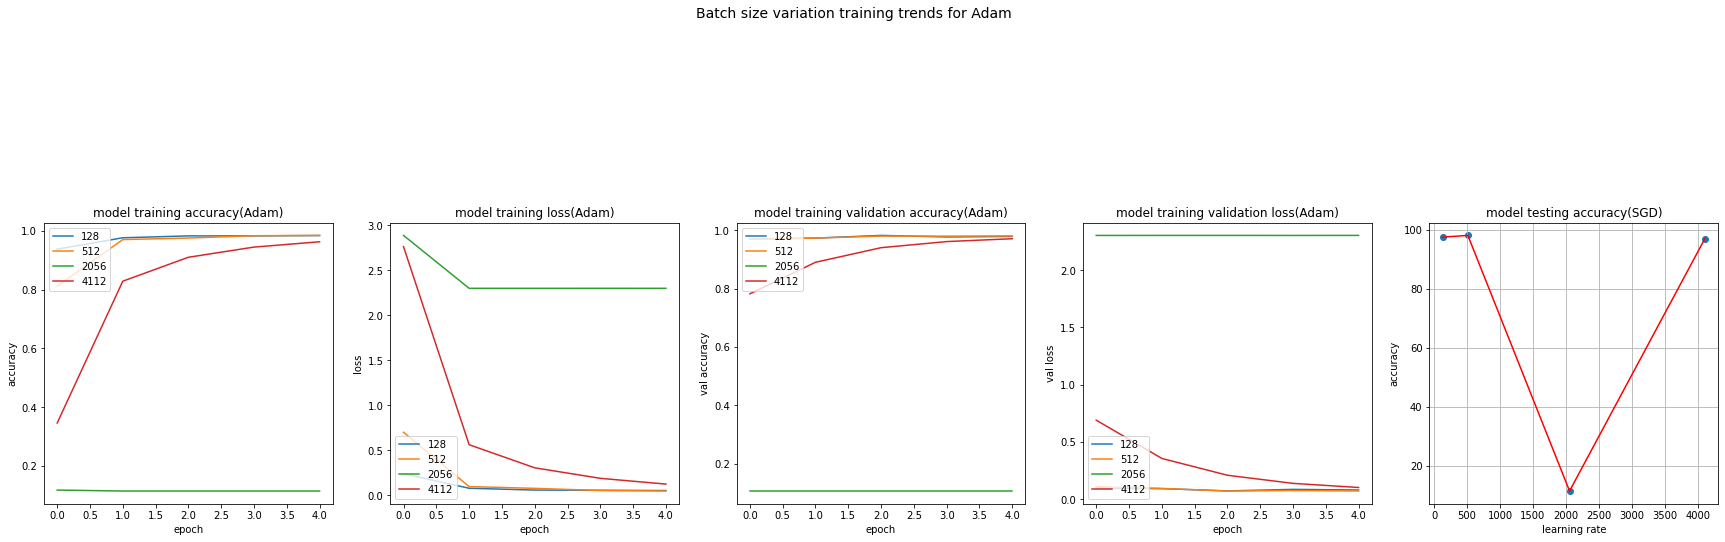

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.plot(adam_BatchVary_History[128].history['accuracy'])
plt.plot(adam_BatchVary_History[512].history['accuracy'])
plt.plot(adam_BatchVary_History[2056].history['accuracy'])
plt.plot(adam_BatchVary_History[4112].history['accuracy'])
plt.title('model training accuracy(Adam)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([128, 512, 2056, 4112], loc='upper left')
plt.subplot(5,5,2)
plt.plot(adam_BatchVary_History[128].history['loss'])
plt.plot(adam_BatchVary_History[512].history['loss'])
plt.plot(adam_BatchVary_History[2056].history['loss'])
plt.plot(adam_BatchVary_History[4112].history['loss'])
plt.title('model training loss(Adam)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend([128, 512, 2056, 4112], loc='lower left')
plt.subplot(5,5,3)
plt.plot(adam_BatchVary_History[128].history['val_accuracy'])
plt.plot(adam_BatchVary_History[512].history['val_accuracy'])
plt.plot(adam_BatchVary_History[2056].history['val_accuracy'])
plt.plot(adam_BatchVary_History[4112].history['val_accuracy'])
plt.title('model training validation accuracy(Adam)')
plt.ylabel('val accuracy')
plt.xlabel('epoch')
plt.legend([128, 512, 2056, 4112], loc='upper left')
plt.subplot(5,5,4)
plt.plot(adam_BatchVary_History[128].history['val_loss'])
plt.plot(adam_BatchVary_History[512].history['val_loss'])
plt.plot(adam_BatchVary_History[2056].history['val_loss'])
plt.plot(adam_BatchVary_History[4112].history['val_loss'])
plt.title('model training validation loss(Adam)')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend([128, 512, 2056, 4112], loc='lower left')
plt.suptitle("Batch size variation training trends for Adam", fontsize=14)
plt.subplot(5,5,5)
plt.scatter([x for x in adam_BatchVary_testResult.keys()], [round(y*100,2) for x,y in adam_BatchVary_testResult.values()] )
plt.plot([x for x in adam_BatchVary_testResult.keys()], [round(y*100,2) for x,y in adam_BatchVary_testResult.values()],'r')
plt.grid()
plt.title('model testing accuracy(SGD)')
plt.ylabel('accuracy')
plt.xlabel('learning rate')
plt.show()

### Analysis

> Same experiments with simitar settings are carried out on a simpler model using mnist dataset. Few interesting point to note.

1. With this model, similar to previous experiments, for SGD low learning rate takes longer to converge and higher learning rate converges fast. for fixed number of epochs higher learning rate produces higher training, validation and testing accuracy. For learning rate 0.001 the model gradually reduced the loss and could attain test accuracy of 85.32% , where as with learnind rate 0.1, the model reduces loss sharply and at the end could achieve test accuracy >98%.

2. The effect of momentum is very vivid for this model and for this dataset. As learning rate 0.001 was slow to converge, I tried to visualize the effect of momentum with this learning rate. Whereas with 0 momentum the test accuracy is only ~85% , with momentum of 0.8, the model is pushed to converge fast and after same number of epochs it achieves >93% accuracy. So it indicates that momentum compensates lower learning rate in search of finding minima. Higher the momentum is, faster the training loss plateaued.

3. Effect of batch size on training using SGD for this model is similar with earlier one. With higher batch size of 4112 the final test accuracy it could achieve is mere ~46%

4. For Adam optizer again it works better with lower learning rate unlike SGD. And for higher learning rates Adam fails to converge and test accuracy falls below 15%.

5. ```The effect of batch size variation for Afam optimizer is very strange for this model. It produces a bowl(or V) like shape for test accuracy with increasing batch size. The training converges for batch size as low as 128 and as high as 4112, with fairly high accuracy, Whereas the model fails to converge with batch size 2056. ``` The adaptive gradient and RMSProp of the adam optimizer may cause the problem as it may take the weight values very far from minima for this batch size and weight update combination.

6. ```Again if we compare the SGD and Adam for this model training and dataset, Adam is faster to converge. Also training process is more stable and very little fluctuation even though we keep on training after convergence achieved while using Adam. Also in best setting in can get higher testing accuracy(>99%) with Adam in comparison with SGD(~98%).```



---

